In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#list of useful imports that  I will use
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

import seaborn as sns
import random
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
# Imputer
#from sklearn.preprocessing import Imputer

from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn_pandas import DataFrameMapper
from feature_engine.imputation import CategoricalImputer

In [3]:
data = pd.read_csv(r'C:\Users\SONA\Music\ITNLP11 - Detection of HAM and Spam Emails\DATASET\12.SPAMVSHAM_SMS.csv')

In [5]:
data

,v1,v2
0,spam,U were outbid by simonwatson5120 on the Shinco...
1,ham,Do you still have the grinder?
2,ham,No. Yes please. Been swimming?
3,ham,No de.am seeing in online shop so that i asked.
4,ham,"Faith makes things possible,Hope makes things ..."
...,...,...
4452,ham,Good. Good job. I like entrepreneurs
4453,ham,Living is very simple.. Loving is also simple....
4454,ham,Msgs r not time pass.They silently say that I ...
4455,ham,What is this 'hex' place you talk of? Explain!


In [7]:
data.shape

(4457, 2)

In [9]:
#Check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4457 entries, 0 to 4456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      4457 non-null   object
 1   v2      4457 non-null   object
dtypes: object(2)
memory usage: 69.8+ KB


In [11]:
#Check the missing values in the data
data.isnull().sum()

v1    0
v2    0
dtype: int64

In [13]:
data['v1'].value_counts()

v1
ham     3868
spam     589
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


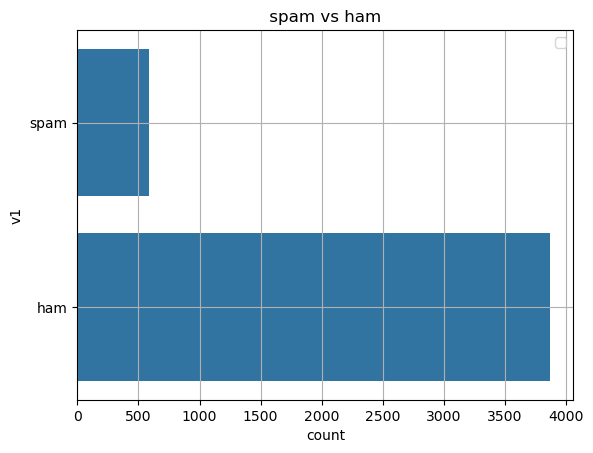

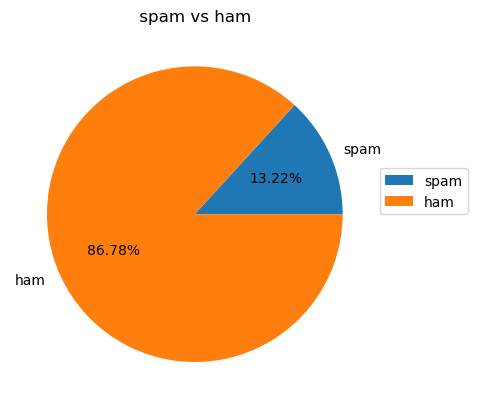

In [15]:
sns.countplot(data['v1'])
plt.grid()
plt.legend()
plt.title(' spam vs ham ')
plt.show()
print(' ')
plt.pie([589,3868],labels=['spam','ham'],autopct='%.2f%%')
plt.legend(loc=(1,0.5))
plt.title(' spam vs ham ')
plt.show()

In [16]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = data[data['v1']== 'ham']
df_minority = data[data['v1']== 'spam']
 
# Downsample majority class and upsample the minority class
df_minority_upsampled = resample(df_minority, replace=True,n_samples=1500,random_state=123) 
df_majority_downsampled = resample(df_majority, replace=True,n_samples=1500,random_state=123) 
 
# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority_downsampled])
 
# Display new class counts
df_upsampled['v1'].value_counts()

v1
spam    1500
ham     1500
Name: count, dtype: int64

In [19]:
# shuffle the DataFrame rows 
data= df_upsampled.sample(frac = 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


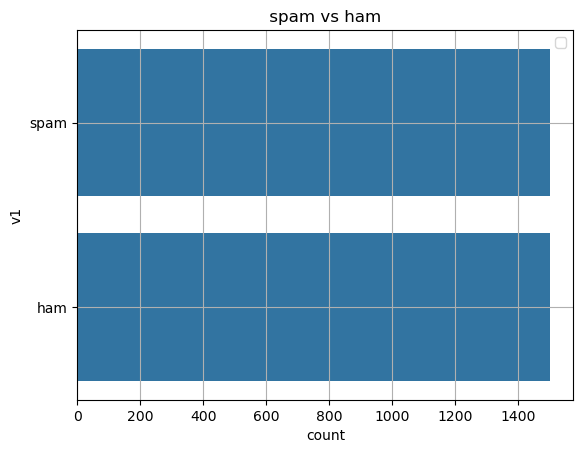

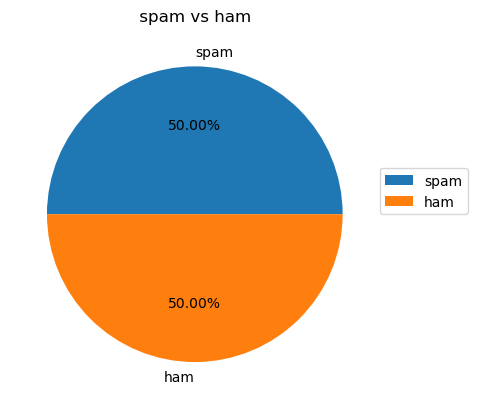

In [21]:
sns.countplot(df_upsampled['v1'])
plt.grid()
plt.legend()
plt.title(' spam vs ham ')
plt.show()
print(' ')
plt.pie([1500,1500],labels=['spam','ham'],autopct='%.2f%%')
plt.legend(loc=(1,0.5))
plt.title(' spam vs ham ')
plt.show()

In [23]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [27]:
data['v2'].head(5)

3134    Hi babe its Jordan, how r u? Im home from abro...
1103    Double your mins & txts on Orange or 1/2 price...
2773    Text & meet someone sexy today. U can find a d...
1522    CDs 4u: Congratulations ur awarded å£500 of CD...
1743    I am taking you for italian food. How about a ...
Name: v2, dtype: object

In [29]:
print("printing some random reviews")
print(7, data['v2'].values[7])
print(234, data['v2'].values[234])
print(17, data['v2'].values[17])

printing some random reviews
7 Latest Nokia Mobile or iPOD MP3 Player +å£400 proze GUARANTEED! Reply with: WIN to 83355 now! Norcorp Ltd.å£1,50/Mtmsgrcvd18+
234 Yo my trip got postponed, you still stocked up?
17 Great NEW Offer - DOUBLE Mins & DOUBLE Txt on best Orange tariffs AND get latest camera phones 4 FREE! Call MobileUpd8 free on 08000839402 NOW! or 2stoptxt T&Cs


In [31]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
       
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [33]:
preprocessed_text = preprocess_text(data['v2'].values)

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 7481.83it/s]


In [35]:
print("printing some random reviews")
print(7, preprocessed_text[7])
print(234, preprocessed_text[234])
print(17, preprocessed_text[17])

printing some random reviews
7 latest nokia mobile ipod mp3 player 400 proze guaranteed reply win 83355 norcorp ltd 1 50 mtmsgrcvd18
234 yo trip got postponed still stocked
17 great new offer double mins double txt best orange tariffs get latest camera phones 4 free call mobileupd8 free 08000839402 2stoptxt cs


In [37]:
from sklearn.preprocessing import LabelEncoder

In [39]:
data['v1'].value_counts()

v1
spam    1500
ham     1500
Name: count, dtype: int64

In [41]:
le = LabelEncoder()
y = le.fit_transform(data['v1'])
y = np.array(y)

In [43]:
y

array([1, 1, 1, ..., 0, 1, 0])

In [45]:
from sklearn.model_selection import train_test_split
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(preprocessed_text, y, test_size=0.3,stratify=y ,random_state=42)

In [47]:
X_train

['hey babe sorry not get sooner gary come fix cause thinks knows not go far ptbo says cost lt gt bucks not know might cheaper find someone not second hand machines right let know want babe',
 'new mobiles 2004 must go txt nokia no 89545 collect today 1 www 4 tc biz 2optout 087187262701 50gbp mtmsg18 txtauction',
 'get official england poly ringtone colour flag yer mobile tonights game text tone flag 84199 optout txt eng stop box39822 w111wx 1 50',
 '18 days euro2004 kickoff u kept informed latest news results daily unsubscribe send get euro stop 83222',
 'lookatme thanks purchase video clip lookatme charged 35p think better not send video mmsto 32323',
 'pls clarify back open return ticket preponed go back kerala',
 'nimbomsons yep phone knows one obviously cos thats real word',
 'chance reality fantasy show call 08707509020 20p per min ntt ltd po box 1327 croydon cr9 5wb 0870 national rate call',
 'case guess see campus lodge',
 'hot live fantasies call 08707509020 20p per min ntt ltd

In [49]:
 X_test

['prof passed papers sem congrats student enna kalaachutaarama prof gud mrng',
 'urgent call 09061749602 landline complimentary 4 tenerife holiday 10 000 cash await collection sae cs box 528 hp20 1yf 150ppm 18',
 'last chance 2 claim ur 150 worth discount vouchers text yes 85023 savamob member offers mobile cs 08717898035 3 00 sub 16 remove txt x stop',
 'private 2003 account statement 07973788240 shows 800 un redeemed points call 08715203649 identifier code 40533 expires 31 10 04',
 'not think spatula hands',
 'ummmmmaah many many happy returns day dear sweet heart happy birthday dear',
 'alrite girl u know gail neva wrong take care sweet worry c u l8tr hun love yaxxx',
 'ffffffffff alright no way meet sooner',
 'noe ben going',
 'senthil group company apnt 5pm',
 'u knw dis no lt gt',
 'camera awarded sipix digital camera call 09061221066 fromm landline delivery within 28 days',
 'next month get upto 50 calls 4 ur standard network charge 2 activate call 9061100010 c wire3 net 1st4ter

In [51]:
y_train.shape

(2100,)

In [53]:
y_test

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,

## Featuraization:- TF-IDF

In [56]:
import pickle
from sklearn import preprocessing

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf.fit(X_train)
import pickle
filename = r'C:\Users\SONA\Music\ITNLP11 - Detection of HAM and Spam Emails\CODING\modified front end\tfidf.pkl'
pickle.dump(tfidf, open(filename, 'wb'))# fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf =tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Normalize Data
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

#Normalize Data
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_test_tfidf.shape)

Train Data Size:  (2100, 794)
Test Data Size:  (900, 794)


### Random Forest with TF-IDF

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

dept = [1, 5, 10, 50, 100, 500, 1000]
n_estimators =  [20, 40, 60, 80, 100, 120]

param_grid={'n_estimators':n_estimators , 'max_depth':dept}
clf = RandomForestClassifier()
model = GridSearchCV(clf,param_grid,scoring='accuracy',n_jobs=-1,cv=3)
model.fit(X_train_tfidf,y_train)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)
optimal_max_depth = model.best_estimator_.max_depth
optimal_n_estimators = model.best_estimator_.n_estimators

optimal n_estimators 80
optimal max_depth 500


AUC on Test data is 0.9811111111111112
AUC on Train data is 0.9995238095238095
---------------------------


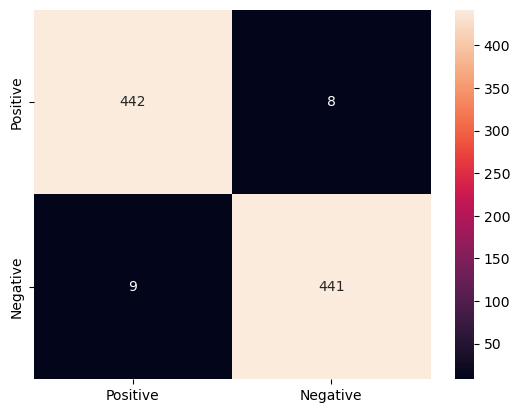

In [65]:
from sklearn.metrics import accuracy_score
#training our model for max_depth=100,n_estimators = 120
clf = RandomForestClassifier(max_depth = optimal_max_depth,n_estimators = optimal_n_estimators)
clf.fit(X_train_tfidf,y_train)

import pickle
filename = r'C:\Users\SONA\Music\ITNLP11 - Detection of HAM and Spam Emails\CODING\modified front end\sms_RF_tfidf.pkl'
pickle.dump(clf, open(filename, 'wb'))

pred_test =clf.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
pred_train = clf.predict(X_train_tfidf)
train_accuracy =accuracy_score(y_train,pred_train)



print("AUC on Test data is " +str(accuracy_score(y_test,pred_test)))
print("AUC on Train data is " +str(accuracy_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['Positive','Negative']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [67]:
original =  ['spam' if x==1 else 'ham' for x in y_test[:20]]
predicted = clf.predict(X_test_tfidf[:20])
pred = []

for i in predicted:
  if i == 1:
    k = 'spam'
    pred.append(k)
  else:
    k = 'ham'
    pred.append(k)
# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,prof passed papers sem congrats student enna k...,ham,ham
1,urgent call 09061749602 landline complimentary...,spam,spam
2,last chance 2 claim ur 150 worth discount vouc...,spam,spam
3,private 2003 account statement 07973788240 sho...,spam,spam
4,not think spatula hands,ham,ham
5,ummmmmaah many many happy returns day dear swe...,ham,ham
6,alrite girl u know gail neva wrong take care s...,ham,ham
7,ffffffffff alright no way meet sooner,ham,ham
8,noe ben going,ham,ham
9,senthil group company apnt 5pm,ham,ham


In [69]:
all_model_result = pd.DataFrame(columns=['METHOD', 'Classifier' , 'Train-Accuracy', 'Test-Accuracy' ])
new = ['TFIDF ','Random forest-Classifier',99, 98]
all_model_result.loc[0] = new

### STOCHASTIC GRADIENT DESCENT

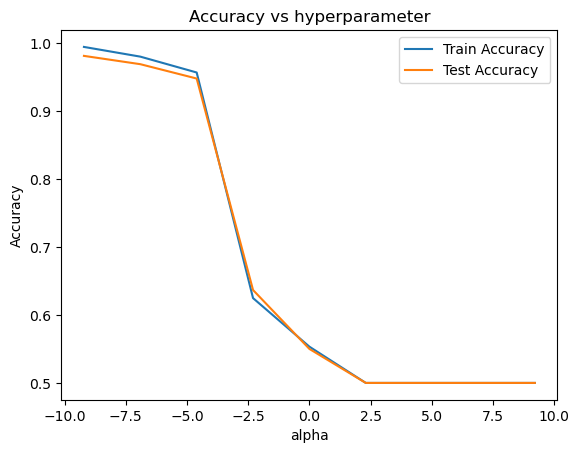

optimal alpha for which auc is maximum :  0.0001


In [72]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import math

alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
test_auc = []

for i in alpha:
    model = SGDClassifier(alpha=i, loss = "hinge") 
    
    model.fit(X_train_tfidf,y_train)
    prob_cv = model.predict(X_test_tfidf)
    test_auc.append(accuracy_score(y_test,prob_cv))
    prob_train = model.predict(X_train_tfidf)
    train_auc.append(accuracy_score(y_train,prob_train))
optimal_alpha= alpha[test_auc.index(max(test_auc))]
alpha=[math.log(x) for x in alpha]

#plot auc vs alpha
x = plt.subplot( )
x.plot(alpha, train_auc, label='Train Accuracy')
x.plot(alpha, test_auc, label='Test Accuracy')
plt.title('Accuracy vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
x.legend()
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)

AUC on Test data is 0.9822222222222222
AUC on Train data is 0.9952380952380953
---------------------------


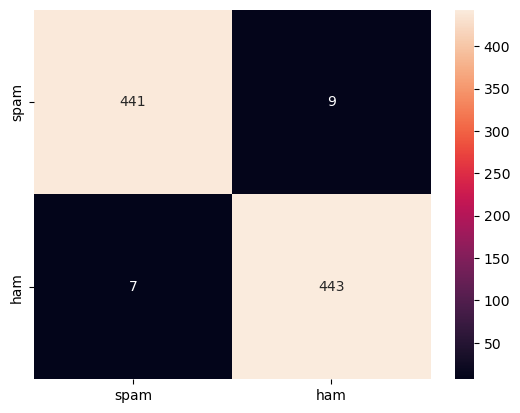

In [78]:
#Testing AUC on Test data
svm = SGDClassifier(alpha=optimal_alpha)

svm.fit(X_train_tfidf,y_train)

filename = r'C:\Users\SONA\Music\ITNLP11 - Detection of HAM and Spam Emails\CODING\modified front end\sms_svm_tfidf.pkl'
pickle.dump(svm, open(filename, 'wb'))

pred_test = svm.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
pred_train = svm.predict(X_train_tfidf)
train_accuracy= accuracy_score(y_train,pred_train) 




print("AUC on Test data is " +str(accuracy_score(y_test,pred_test)))
print("AUC on Train data is " +str(accuracy_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
from sklearn.metrics import confusion_matrix
class_names = ['spam','ham']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [80]:
original =  ['spam' if x==1 else 'ham' for x in y_test[:20]]
predicted = svm.predict(X_test_tfidf[:20])
pred = []

for i in predicted:
  if i == 1:
    k = 'spam'
    pred.append(k)
  else:
    k = 'ham'
    pred.append(k)
# Creating a data frame
df = pd.DataFrame(list(zip(X_test[:20],original, pred,)), 
               columns =['Text','original_Classlabel', 'predicted_classlebel'])
df

,Text,original_Classlabel,predicted_classlebel
0,prof passed papers sem congrats student enna k...,ham,spam
1,urgent call 09061749602 landline complimentary...,spam,spam
2,last chance 2 claim ur 150 worth discount vouc...,spam,spam
3,private 2003 account statement 07973788240 sho...,spam,spam
4,not think spatula hands,ham,ham
5,ummmmmaah many many happy returns day dear swe...,ham,ham
6,alrite girl u know gail neva wrong take care s...,ham,ham
7,ffffffffff alright no way meet sooner,ham,ham
8,noe ben going,ham,ham
9,senthil group company apnt 5pm,ham,ham


In [82]:
new = ['TFIDF ','SGD classifier',99, 98]
all_model_result.loc[1] = new

In [84]:
all_model_result

,METHOD,Classifier,Train-Accuracy,Test-Accuracy
0,TFIDF,Random forest-Classifier,99,98
1,TFIDF,SGD classifier,99,98
